<a href="https://colab.research.google.com/github/AmirJlr/RecSys/blob/master/pytorch-geometric/02_Link_Regression_on_Movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MovieLens Rating Prediction Workshop Notebook

This notebook runs faster on a GPU runtime. To enable it, go to Edit > Notebook Settings > Hardware Accelerator > GPU.


## Setup

In [3]:
import torch

print(torch.__version__)


2.6.0+cu124


In [4]:
# Install required packages
import os

os.environ['TORCH'] = torch.__version__
!pip install -q pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install -q sentence_transformers
!pip3 install -q fuzzywuzzy[speedup]
!pip install -q numpy
!pip install -q captum

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Link Regression on the MovieLens Dataset

This notebook shows how to load a set of `*.csv` files into a `torch_geometric.data.HeteroData` object and how to train a [heterogeneous graph model](https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html#hgtutorial).

We are going to use the [Movielens dataset](https://grouplens.org/datasets/movielens/), which is collected by the GroupLens Research group. The toy dataset describes movies, users, and their ratings. We are going to predict the rating of a user for a movie.

## Data Ingestion

In [5]:
from torch_geometric.data import download_url, extract_zip
import pandas as pd

dataset_name = 'ml-latest-small'

url = f'https://files.grouplens.org/datasets/movielens/{dataset_name}.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = f'./{dataset_name}/movies.csv'
ratings_path = f'./{dataset_name}/ratings.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [6]:
# Load the entire ratings dataframe into memory:
ratings_df = pd.read_csv(ratings_path)[["userId", "movieId", "rating"]]

# Load the entire movie dataframe into memory:
movies_df = pd.read_csv(movies_path, index_col='movieId')


In [7]:
ratings_df.head(3)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0


In [8]:
ratings_df.shape

(100836, 3)

In [9]:
movies_df.head(3)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance


Additionally, let's add our ratings to the dataset to get predictions for movies we haven't seen yet.

There are two ways to add ratings:
1. **Add ratings manually**
2. **Upload IMDB ratings**


### Add your ratings manually


We recommend adding at least 10 ratings. Let's first check out the most rated movies. Additional movies in the table are: *Avatar*, *The Dark Knight*, *Pretty Women*,
*Titanic*, *The Lion King*, *Jurassic Park*, *The Matrix*, *The Lord of the Rings* and *The Avengers*. Please note that the article in the movie title is often at the end of the title.

In [10]:
ratings_df['movieId'].value_counts().head(10)

,count
movieId,
356,329
318,317
296,307
593,279
2571,278
260,251
480,238
110,237
589,224


In [11]:
from fuzzywuzzy import fuzz

# Specify your userId
our_user_id = ratings_df['userId'].max() + 1

print('Most rated movies:')
print('==================')

most_rated_movies = ratings_df['movieId'].value_counts().head(10)
print(movies_df.loc[most_rated_movies.index][["title"]])

# Initialize your rating list
ratings = []

Most rated movies:
                                             title
movieId                                           
356                            Forrest Gump (1994)
318               Shawshank Redemption, The (1994)
296                            Pulp Fiction (1994)
593               Silence of the Lambs, The (1991)
2571                            Matrix, The (1999)
260      Star Wars: Episode IV - A New Hope (1977)
480                           Jurassic Park (1993)
110                              Braveheart (1995)
589              Terminator 2: Judgment Day (1991)
527                        Schindler's List (1993)


In [12]:
# Add your ratings here:
num_ratings = 3
while len(ratings) < num_ratings:
    print(f'Select the {len(ratings) + 1}. movie:')
    print('=====================================')
    movie = input('Please enter the movie title: ')
    movies_df['title_score'] = movies_df['title'].apply(lambda x: fuzz.ratio(x, movie))
    print(movies_df.sort_values('title_score', ascending=False)[['title']].head(5))
    movie_id = input('Please enter the movie id: ')
    if not movie_id:
        continue
    movie_id = int(movie_id)
    rating = float(input('Please enter your rating: '))
    if not rating:
        continue
    assert 0 <= rating <= 5
    ratings.append({'movieId': movie_id, 'rating': rating, 'userId': our_user_id})
    print()

Select the 1. movie:
Please enter the movie title: goodfellas
                             title
movieId                           
1213             Goodfellas (1990)
63131           Role Models (2008)
3344            Blood Feast (1963)
95175    Front of the Class (2008)
111364             Godzilla (2014)
Please enter the movie id: 1213
Please enter your rating: 5

Select the 2. movie:
Please enter the movie title: Habbit
                      title
movieId                    
153070       Rabbits (2002)
82767    Rabbit Hole (2010)
1967       Labyrinth (1986)
26422           Hair (1979)
3898            Bait (2000)
Please enter the movie id: 
Select the 2. movie:
Please enter the movie title: habit
                     title
movieId                   
153070      Rabbits (2002)
152270     The Wait (2015)
3898           Bait (2000)
1967      Labyrinth (1986)
6565     Seabiscuit (2003)
Please enter the movie id: 153070
Please enter your rating: 3.5

Select the 3. movie:
Please enter the m

In [13]:
ratings

[{'movieId': 1213, 'rating': 5.0, 'userId': 611},
 {'movieId': 153070, 'rating': 3.5, 'userId': 611},
 {'movieId': 79132, 'rating': 4.0, 'userId': 611}]

In [14]:
# Add your ratings to the rating dataframe
ratings_df = pd.concat([ratings_df, pd.DataFrame.from_records(ratings)])

In [15]:
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100834,610,168252,5.0
100835,610,170875,3.0
0,611,1213,5.0
1,611,153070,3.5


### Upload your IMDB ratings

If you have an IMDB account, you can also upload your IMDB ratings. To do so, please follow the following steps:
1. Go to https://www.imdb.com/
2. Login to your account
3. Go to `Your Ratings`
4. Click on `Export Ratings` after clicking the three dots in the upper right corner
5. Upload the downloaded `ratings.csv` file to the current directory
6. Rename the file to `imdb_ratings.csv`
7. Run the following cell


In [16]:
# # Select our userId
# our_user_id = ratings_df['userId'].max() + 1

# # Load the IMDB ratings:
# imdb_rating_path = f'./imdb_ratings.csv'
# imdb_ratings_df = pd.read_csv(imdb_rating_path)
# imdb_ratings_df.columns = imdb_ratings_df.columns.str.strip().str.lower()

# # The IMDB movie titles / ids do not match the movie titles /ids in the movielens dataframes
# # so we need to map them:
# imdb_ratings_df['title'] = imdb_ratings_df['title'] + ' (' + imdb_ratings_df['year'].astype(str) + ')'
# imdb_ratings_df['title'] = imdb_ratings_df['title'].str.strip()
# movies_df['title'] = movies_df['title'].str.strip()
# imdb_ratings_df = imdb_ratings_df.merge(movies_df['title'].reset_index(), on='title', how='inner', )

# # The ratings are on a scale from 1 to 10, so we need to transform them to a scale from 0 to 5:
# imdb_ratings_df['rating'] = (imdb_ratings_df['your rating'] / 2).astype(int)

# # Your ratings that we are going to use:
# print('Your IMDB ratings:')
# print('==================')
# print(imdb_ratings_df[['title', 'rating']].head(10))

# # Finally, we can add the ratings to the ratings data frame:
# imdb_ratings_df['userId'] = our_user_id
# ratings_df = pd.concat([ratings_df, imdb_ratings_df[['movieId', 'rating', 'userId']]])

## Data Preprocessing

We are going to use the genre as well as the title of the movie as node features. For the `title` features, we are going to use a pre-trained [sentence transformer](https://www.sbert.net/) model to encode the title into a vector.
For the `genre` features, we are going to use a one-hot encoding.

In [17]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer

# One-hot encode the genres:
genres = movies_df['genres'].str.get_dummies('|').values
genres = torch.from_numpy(genres).to(torch.float)
genres

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [18]:
# Load the pre-trained sentence transformer model and encode the movie titles:
model = SentenceTransformer('all-MiniLM-L6-v2')
with torch.no_grad():
    titles = model.encode(movies_df['title'].tolist(), convert_to_tensor=True, show_progress_bar=True)
    titles = titles.cpu()


titles

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/305 [00:00<?, ?it/s]

tensor([[-0.0828,  0.0530,  0.0536,  ...,  0.0226,  0.0538,  0.1030],
        [-0.1053,  0.1508, -0.0264,  ...,  0.0106, -0.0726,  0.0086],
        [-0.0988,  0.0176, -0.0527,  ..., -0.0120,  0.0303,  0.0004],
        ...,
        [-0.1115,  0.0310, -0.0177,  ...,  0.0147,  0.0299,  0.0200],
        [ 0.0366,  0.0137,  0.0315,  ..., -0.0516, -0.0143,  0.1012],
        [-0.0500, -0.0141, -0.0031,  ...,  0.0320,  0.0546, -0.0271]])

In [19]:
### Final Movie Features
# Concatenate the genres and title features:
movie_features = torch.cat([genres, titles], dim=-1)
movie_features.shape

torch.Size([9742, 404])

In [20]:
# We don't have user features, which is why we use an identity matrix => One-Hot matrix
user_features = torch.eye(len(ratings_df['userId'].unique()))
user_features.shape

torch.Size([611, 611])

The `ratings.csv` file contains the ratings of users for movies. From this
file we are extracting the `userId`. We create a mapping from the `userId`
to a unique consecutive value in the range `[0, num_users]`. This is needed as we want our final data representation to be as compact as possible, *e.g.*, the representation of a user in the first row should be accessible via `x[0]`.
The same we do for the `movieId`.
Afterwards, we obtain the final `edge_index` representation of shape `[2, num_ratings]` from `ratings.csv` by merging mapped user and movie indices with the raw indices given by the original data frame.


In [21]:
# Create a mapping from the userId to a unique consecutive value in the range [0, num_users]:
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedUserId': pd.RangeIndex(len(unique_user_id))
    })
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()

Mapping of user IDs to consecutive values:
   userId  mappedUserId
0       1             0
1       2             1
2       3             2
3       4             3
4       5             4



In [22]:
# Create a mapping from the movieId to a unique consecutive value in the range [0, num_movies]:
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedMovieId': pd.RangeIndex(len(unique_movie_id))
    })
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())
print()

Mapping of movie IDs to consecutive values:
   movieId  mappedMovieId
0        1              0
1        3              1
2        6              2
3       47              3
4       50              4



In [23]:
# Merge the mappings with the original data frame:
ratings_df = ratings_df.merge(unique_user_id, on='userId')
ratings_df.head(3)

,userId,movieId,rating,mappedUserId
0,1,1,4.0,0
1,1,3,4.0,0
2,1,6,4.0,0


In [24]:
ratings_df = ratings_df.merge(unique_movie_id, on='movieId')
ratings_df.head(3)

,userId,movieId,rating,mappedUserId,mappedMovieId
0,1,1,4.0,0,0
1,1,3,4.0,0,1
2,1,6,4.0,0,2


In [25]:
# With this, we are ready to create the edge_index representation in COO format
# following the PyTorch Geometric semantics:
edge_index = torch.stack([
    torch.tensor(ratings_df['mappedUserId'].values),
    torch.tensor(ratings_df['mappedMovieId'].values)]
    , dim=0)

assert edge_index.shape == (2, len(ratings_df))

In [26]:
print("Final edge indices pointing from users to movies:")
print("================================================")
print(edge_index[:, :10])

Final edge indices pointing from users to movies:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])


## Heterogeneous Graph Construction

With this we are ready to initialize our heterogeneous graph data object and pass the
necessary information to it.

We also take care of adding reverse edges to the `HeteroData` object. This allows our GNN
model to use both directions of the edges for the message passing.

In [27]:
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

# Create the heterogeneous graph data object:
data = HeteroData()

# Add the user nodes:
data['user'].x = user_features  # [num_users, num_features_users]

# Add the movie nodes:
data['movie'].x = movie_features  # [num_movies, num_features_movies]

# Add the rating edges:
data['user', 'rates', 'movie'].edge_index = edge_index  # [2, num_ratings]

# Add the rating labels:
rating = torch.from_numpy(ratings_df['rating'].values).to(torch.float)
data['user', 'rates', 'movie'].edge_label = rating  # [num_ratings]

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

# With the above transformation we also got reversed labels for the edges.
# We are going to remove them:
del data['movie', 'rev_rates', 'user'].edge_label

assert data['user'].num_nodes == len(unique_user_id)
assert data['user', 'rates', 'movie'].num_edges == len(ratings_df)
assert data['movie'].num_features == 404 # 20 from genres + 284 from sentence_transform model on movie_title

data

HeteroData(
  user={ x=[611, 611] },
  movie={ x=[9742, 404] },
  (user, rates, movie)={
    edge_index=[2, 100839],
    edge_label=[100839],
  },
  (movie, rev_rates, user)={ edge_index=[2, 100839] }
)

## Dataset Splitting

We can now split our data into a training, validation and test set. We are going to use
the `T.RandomLinkSplit` transform from PyG to do this. This transform will randomly
split the links with their label/rating into training, validation and test set.
We are going to use 80% of the edges for training, 10% for validation and 10% for testing.

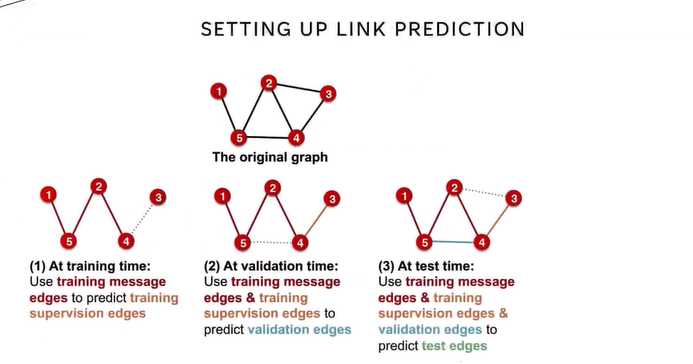

In [28]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)
train_data, val_data, test_data

(HeteroData(
   user={ x=[611, 611] },
   movie={ x=[9742, 404] },
   (user, rates, movie)={
     edge_index=[2, 80673],
     edge_label=[80673],
     edge_label_index=[2, 80673],
   },
   (movie, rev_rates, user)={ edge_index=[2, 80673] }
 ),
 HeteroData(
   user={ x=[611, 611] },
   movie={ x=[9742, 404] },
   (user, rates, movie)={
     edge_index=[2, 80673],
     edge_label=[10083],
     edge_label_index=[2, 10083],
   },
   (movie, rev_rates, user)={ edge_index=[2, 80673] }
 ),
 HeteroData(
   user={ x=[611, 611] },
   movie={ x=[9742, 404] },
   (user, rates, movie)={
     edge_index=[2, 90756],
     edge_label=[10083],
     edge_label_index=[2, 10083],
   },
   (movie, rev_rates, user)={ edge_index=[2, 90756] }
 ))

## Graph Neural Network

We are now ready to define our GNN model. We are going to use a simple GNN model with
two message passing layers for the encoding of the user and movie nodes.
Additionally, we are going to use a decoder to predict the rating for the encoded
user-movie combination.

In [29]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1) # concatenate

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv((-1, -1), 32, aggr=mean)
      (movie__rev_rates__user): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv((-1, -1), 32, aggr=mean)
      (movie__rev_rates__user): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)


## Training a Heterogeneous GNN

Training our GNN is then similar to training any PyTorch model.
We move the model to the desired device, and initialize an optimizer that takes care of adjusting model parameters via stochastic gradient descent.

The training loop applies the forward computation of the model, computes the loss from ground-truth labels and obtained predictions, and adjusts model parameters via back-propagation and stochastic gradient descent.


In [32]:
from torch.utils.tensorboard import SummaryWriter

# %load_ext tensorboard
# %tensorboard --logdir runs

In [33]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)

    target = train_data['user', 'movie'].edge_label

    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    data = data.to(device)
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)



writer = SummaryWriter('runs/Encoder-Decoder-100-epoch')
for epoch in range(1, 100):
    train_data = train_data.to(device)
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)

    writer.add_scalar('train_rmse', train_rmse, epoch)
    writer.add_scalar('val_rmse', val_rmse, epoch)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}')

Epoch: 001, Loss: 13.1727, Train: 3.4840, Val: 3.4873
Epoch: 002, Loss: 12.1382, Train: 3.2116, Val: 3.2158
Epoch: 003, Loss: 10.3143, Train: 2.7502, Val: 2.7560
Epoch: 004, Loss: 7.5634, Train: 1.9699, Val: 1.9785
Epoch: 005, Loss: 3.8805, Train: 1.0616, Val: 1.0601
Epoch: 006, Loss: 1.1271, Train: 1.8137, Val: 1.7893
Epoch: 007, Loss: 4.7103, Train: 1.7781, Val: 1.7527
Epoch: 008, Loss: 3.8114, Train: 1.2630, Val: 1.2428
Epoch: 009, Loss: 1.5952, Train: 1.0599, Val: 1.0589
Epoch: 010, Loss: 1.1233, Train: 1.3261, Val: 1.3330
Epoch: 011, Loss: 1.7586, Train: 1.5560, Val: 1.5640
Epoch: 012, Loss: 2.4213, Train: 1.6395, Val: 1.6474
Epoch: 013, Loss: 2.6878, Train: 1.5918, Val: 1.5995
Epoch: 014, Loss: 2.5340, Train: 1.4419, Val: 1.4490
Epoch: 015, Loss: 2.0791, Train: 1.2327, Val: 1.2379
Epoch: 016, Loss: 1.5196, Train: 1.0534, Val: 1.0529
Epoch: 017, Loss: 1.1097, Train: 1.0660, Val: 1.0558
Epoch: 018, Loss: 1.1363, Train: 1.2297, Val: 1.2128
Epoch: 019, Loss: 1.5121, Train: 1.3194, Va

## Evaluation

From the validation results, our model can generalize well to unseen data. The val RMSE is should be around 0.9, meaning that, on average our model is off by 0.9 stars. We can now evaluate our model on the test set and take a closer look into the predictions.

In [34]:
with torch.no_grad():
    test_data = test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = test_data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()

    print(f'Test RMSE: {rmse:.4f}')

Test RMSE: 0.9143


In [35]:
userId = test_data['user', 'movie'].edge_label_index[0].cpu().numpy()
movieId = test_data['user', 'movie'].edge_label_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

print(pd.DataFrame({'userId': userId, 'movieId': movieId, 'rating': pred, 'target': target}))

       userId  movieId    rating  target
0         386     2072  3.290342     4.5
1         533     4729  3.635522     5.0
2         609     1915  3.857379     5.0
3         609      236  3.730331     4.0
4         491      674  3.940824     3.0
...       ...      ...       ...     ...
10078     185     1799  3.946492     4.0
10079      40     1159  3.460856     4.0
10080     285      863  3.523893     3.5
10081     367     1587  2.495796     3.0
10082     306     6606  2.370362     2.5

[10083 rows x 4 columns]


## Movie recommendations

We can now use the model to generate ratings for a movie we haven't seen.


In [36]:
# Your mappedUserId
mapped_user_id = unique_user_id[unique_user_id['userId'] == our_user_id]['mappedUserId'].values[0]
mapped_user_id

610

In [37]:
# Select movies that you haven't seen before
movies_rated = ratings_df[ratings_df['mappedUserId'] == mapped_user_id]
movies_not_rated = movies_df[~movies_df.index.isin(movies_rated['movieId'])]
movies_not_rated = movies_not_rated.merge(unique_movie_id, on='movieId')
movie = movies_not_rated.sample(1)

print(f"The movie we want to predict a raiting for is:  {movie['title'].item()}")

The movie we want to predict a raiting for is:  Aqua Teen Hunger Force Colon Movie Film for Theaters (2007)


In [38]:
# Create new `edge_label_index` between the user and the movie
edge_label_index = torch.tensor([
    mapped_user_id,
    movie.mappedMovieId.item()])


with torch.no_grad():
    test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict, edge_label_index)
    pred = pred.clamp(min=0, max=5).detach().cpu().numpy()

In [39]:
pred.item()

3.881174087524414

## Explaining the Predictions

PyTorch Geometric also provides a way to explain the predictions of a GNN. Let's check which movie ratings have influenced this prediction the most.

We will use the [captum](https://captum.ai/) library to explain the predictions.

In [40]:
from torch_geometric.explain import Explainer, CaptumExplainer

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
    node_mask_type=None,
    edge_mask_type='object',
)

explanation = explainer(
    test_data.x_dict, test_data.edge_index_dict, index=0,
    edge_label_index=edge_label_index).cpu().detach()
explanation

HeteroExplanation(
  prediction=[1],
  target=[1],
  index=[1],
  edge_label_index=[2],
  user={ x=[611, 611] },
  movie={ x=[9742, 404] },
  (user, rates, movie)={
    edge_mask=[90756],
    edge_index=[2, 90756],
  },
  (movie, rev_rates, user)={
    edge_mask=[90756],
    edge_index=[2, 90756],
  }
)

In [41]:
# User to movie link + attribution
user_to_movie = explanation['user', 'movie'].edge_index.numpy().T
user_to_movie_attr = explanation['user', 'movie'].edge_mask.numpy().T
user_to_movie_df = pd.DataFrame(
    np.hstack([user_to_movie, user_to_movie_attr.reshape(-1,1)]),
    columns = ['mappedUserId', 'mappedMovieId', 'attr']
)

# Movie to user link + attribution
movie_to_user = explanation['movie', 'user'].edge_index.numpy().T
movie_to_user_attr = explanation[ 'movie', 'user'].edge_mask.numpy().T
movie_to_user_df = pd.DataFrame(
    np.hstack([movie_to_user, movie_to_user_attr.reshape(-1,1)]),
    columns = ['mappedMovieId', 'mappedUserId','attr']
)
explanation_df = pd.concat([user_to_movie_df, movie_to_user_df])
explanation_df[["mappedUserId", "mappedMovieId"]] = explanation_df[["mappedUserId", "mappedMovieId"]].astype(int)

print(f"Attribtion for all edges towards prediction of movie rating of movie:\n {movie['title'].item()}")
print("==========================================================================================")
print(explanation_df.sort_values(by='attr'))

Attribtion for all edges towards prediction of movie rating of movie:
 Aqua Teen Hunger Force Colon Movie Film for Theaters (2007)
       mappedUserId  mappedMovieId      attr
55944           566           8871 -0.003685
14258           447             74 -0.000075
35993           306             74 -0.000068
72875           447            244 -0.000064
8596            566            244 -0.000056
...             ...            ...       ...
88687           610           8871  0.008886
14947           386           7366  0.066059
88687           610           8871  0.083579
38655           610             74  0.122430
12971           610            244  0.130520

[181512 rows x 3 columns]


In [42]:
# Select links that connect to our user
explanation_df = explanation_df[explanation_df['mappedUserId'] == mapped_user_id]

# We group the attribution scores by movie
explanation_df = explanation_df.groupby('mappedMovieId').sum()

# Merge with movies_df to receive title
# But first, we need to add the original id
explanation_df = explanation_df.merge(unique_movie_id, on='mappedMovieId')
explanation_df = explanation_df.merge(movies_df, on='movieId')

pd.options.display.float_format = "{:,.9f}".format

print("Top movies that influenced the prediction:")
print("==============================================")
print(explanation_df.sort_values(by='attr', ascending=False, key= lambda x: abs(x))[['title', 'attr']].head())

Top movies that influenced the prediction:
               title        attr
1   Inception (2010) 0.130655729
0  Goodfellas (1990) 0.122588852
2     Rabbits (2002) 0.092465529
